In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import importlib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from BBB import BayesianRegressionNetwork
import BBB
from utils.PreProcessing import  normalize, process_cells
from utils.PlotPrediction import prediction, Plot_predictions
import csv

import BatteryDataToolkit
from BatteryDataToolkit import DataInitializer, DataVisualizer

def reloader_init():
    importlib.reload(BatteryDataToolkit)
    return BatteryDataToolkit.DataInitializer

def reloader_BBB():
    importlib.reload(BBB)
    return BBB.BayesianRegressionNetwork

## Loading Oxford Dataset

In [ ]:
file_path = './Datasets/Oxford/Oxford_Battery_Degradation_Dataset_1.mat'

Conditions = [1,3,7,8]

data_loader = DataInitializer(cutoff=0.1, fs=5, order=2, window_size=30)

data_dict = {Condition: data_loader.load_oxford(file_path = file_path, cell_number = Condition) for Condition in Conditions}

C0 = data_dict[1]['ch_cap'][0]
print(f'\nInitial Capacity {C0}')

Cell #1 Data successfully loaded from: ./Datasets/Oxford/Oxford_Battery_Degradation_Dataset_1.mat
Cell #3 Data successfully loaded from: ./Datasets/Oxford/Oxford_Battery_Degradation_Dataset_1.mat
Cell #7 Data successfully loaded from: ./Datasets/Oxford/Oxford_Battery_Degradation_Dataset_1.mat
Cell #8 Data successfully loaded from: ./Datasets/Oxford/Oxford_Battery_Degradation_Dataset_1.mat

Initial Capacity 724.1208914093187


## Prepare Data for Training

In [7]:
train_conditions = [1, 3, 7] #[1, 3, 7, 8]
test_conditions = [8]

In [8]:
selected_HIs_dch_list = ['discharge_time', 'dv_dt_mean', 'voltage_integral', 'dv_dt_min']
selected_HIs_ch_list = ['charge_time', 'voltage_std', 'dv_dt_mean', 'dv_dt_std', 'voltage_integral', 'voltage_plateau_time']

# Toggle outlier removal
REMOVE_OUTLIERS = True
Z_THRESH = 2

# Process data
Cycles_train, Capacities_train, RULs_train, Temps_train, Volts_train, HIs_ch_train, HIs_dch_train, RUL_list, Capacity_list, Cycle_list = process_cells(
    cell_ids = train_conditions, data_dict = data_dict, C0=C0, ch_dch= 'ch', selected_HIs_dch_list= selected_HIs_dch_list, selected_HIs_ch_list= selected_HIs_ch_list,  remove_outliers=REMOVE_OUTLIERS, z_thresh=Z_THRESH)

Cycles_test, Capacities_test, RULs_test, Temps_test, Volts_test, HIs_ch_test, HIs_dch_test, _, _, _ = process_cells(
    cell_ids = test_conditions, data_dict = data_dict, C0=C0, ch_dch= 'ch', selected_HIs_dch_list= selected_HIs_dch_list, selected_HIs_ch_list= selected_HIs_ch_list,  remove_outliers=REMOVE_OUTLIERS, z_thresh=Z_THRESH)

# Select and concatenate desired HIs
selected_HIs_dch_train = tf.concat([HIs_dch_train[hi] for hi in selected_HIs_dch_list], axis=1)
selected_HIs_ch_train = tf.concat([HIs_ch_train[hi] for hi in selected_HIs_ch_list], axis=1)
inputs_train = tf.concat([selected_HIs_dch_train, selected_HIs_ch_train, Cycles_train], axis=1)
outputs_train = Capacities_train

selected_HIs_dch_test = tf.concat([HIs_dch_test[hi] for hi in selected_HIs_dch_list], axis=1)
selected_HIs_ch_test = tf.concat([HIs_ch_test[hi] for hi in selected_HIs_ch_list], axis=1)
inputs_test = tf.concat([selected_HIs_dch_test, selected_HIs_ch_test, Cycles_test], axis=1)
outputs_test = Capacities_test

# Normalize inputs
inputs_train_scaled, inputs_test_scaled, scaler = normalize(inputs_train, inputs_test)
inputs_train = tf.convert_to_tensor(inputs_train_scaled, dtype=tf.float32)
inputs_test = tf.convert_to_tensor(inputs_test_scaled, dtype=tf.float32)

# Train BNNs

## SoH Estimation

Train Cell Numbers: [1, 3, 7], Test Cell Number: [8]
Epoch 1/2000 - Train Loss: 42339100.0000 - Val Loss: 13597887.0000
Epoch 2/2000 - Train Loss: 42337080.0000 - Val Loss: 13597109.0000
Epoch 3/2000 - Train Loss: 42334772.0000 - Val Loss: 13595853.0000
Epoch 4/2000 - Train Loss: 42331096.0000 - Val Loss: 13594236.0000
Epoch 5/2000 - Train Loss: 42326128.0000 - Val Loss: 13591772.0000
Epoch 6/2000 - Train Loss: 42318984.0000 - Val Loss: 13588638.0000
Epoch 7/2000 - Train Loss: 42308568.0000 - Val Loss: 13583843.0000
Epoch 8/2000 - Train Loss: 42294456.0000 - Val Loss: 13577354.0000
Epoch 9/2000 - Train Loss: 42274428.0000 - Val Loss: 13567192.0000
Epoch 10/2000 - Train Loss: 42246752.0000 - Val Loss: 13554520.0000
Epoch 11/2000 - Train Loss: 42206288.0000 - Val Loss: 13538545.0000
Epoch 12/2000 - Train Loss: 42159400.0000 - Val Loss: 13516374.0000
Epoch 13/2000 - Train Loss: 42094176.0000 - Val Loss: 13487069.0000
Epoch 14/2000 - Train Loss: 42008312.0000 - Val Loss: 13451137.0000
Epoc

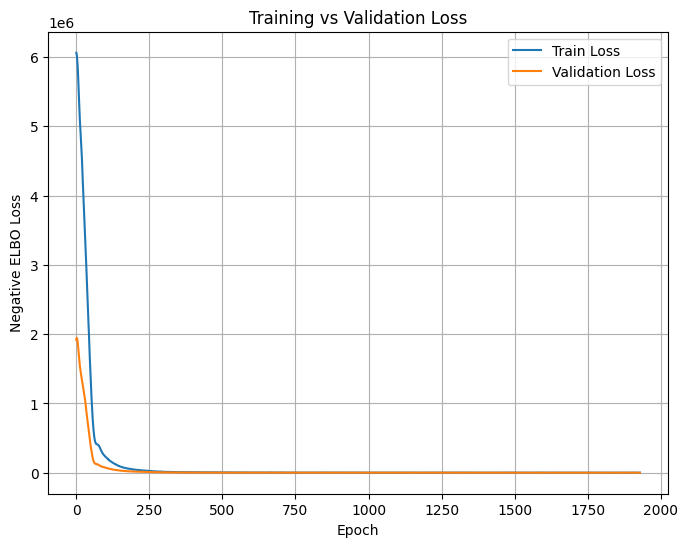

In [9]:
num_features = len(selected_HIs_dch_list)+ len(selected_HIs_ch_list)
print(f'Train Cell Numbers: {train_conditions}, Test Cell Number: {test_conditions}')

SoH_RUL = 'SoH'

# Create the Bayesian model for SoH Estimation
bayesian_model_SoH = BayesianRegressionNetwork(
    input_dim=num_features,
    hidden_layers=[32, 16, 8],
    output_dim=1,
    samples=5,
    num_batches=20,
    pi=0.5,
    sigma1=5,
    sigma2=0.1,
    google_init=True,
    scalar_mixture_prior=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

train_losses, val_losses = bayesian_model_SoH.fit_bbb(
    inputs_train, Capacities_train,
    inputs_test, Capacities_test,
    optimizer=optimizer,
    num_features= num_features,
    epochs=2000,
    use_early_stopping=False,
    patience=100,
    verbose=True)

bayesian_model_SoH.plot_losses()

Mean Absolute Error (MAE): 0.0022
Mean Absolute Percentage Error (MAPE): 0.0025
Root Mean Squared Error (RMSE): 0.0026
R² Score: 0.9986


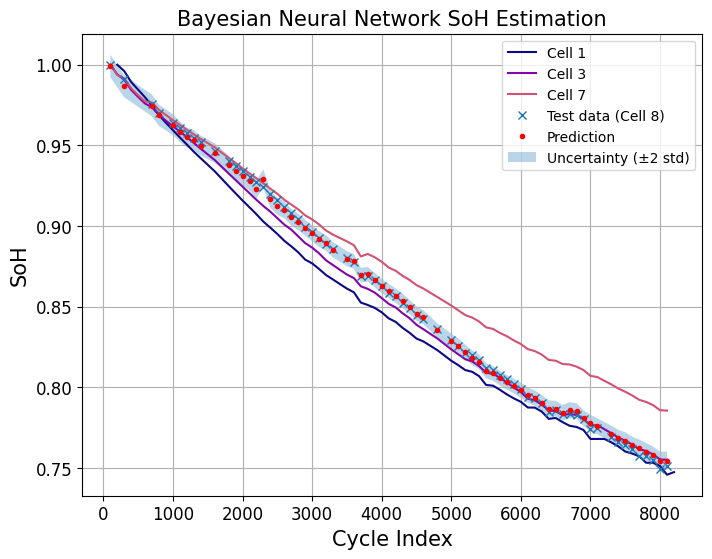

In [10]:
SoH_RUL = 'SoH'
output_test = Capacities_test
cycle_filtered, SoH_true_filtered, SoH_pred_filtered, mean_pred, std_pred = prediction(model = bayesian_model_SoH, SoH_RUL = SoH_RUL,
                                                                                    input_test = inputs_test, output_test=output_test, num_features=num_features, num_path=50, threshold=2)

mae = mean_absolute_error(SoH_true_filtered, SoH_pred_filtered)
mape = mean_absolute_percentage_error(SoH_true_filtered, SoH_pred_filtered)
rmse = np.sqrt(mean_squared_error(SoH_true_filtered, SoH_pred_filtered))
r2 = r2_score(SoH_true_filtered, SoH_pred_filtered)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Plot_predictions(model=bayesian_model_SoH, inputs_test=inputs_test, output_test=output_test,
                Cycle_list=Cycle_list, Capacity_list=Capacity_list, RUL_list=RUL_list,
                SoH_RUL=SoH_RUL, num_features=num_features,
                train_conditions=train_conditions, test_conditions=test_conditions, num_path=50)

In [ ]:
# Save SoH Predictions

data = [SoH_true_filtered, SoH_pred_filtered]

with open(f'SoH_Cell{test_conditions[0]}.csv', 'w', newline='') as file:
         writer = csv.writer(file)
         writer.writerows(data)

## RUL Prediction

Train Cell Numbers: [1, 3, 7], Test Cell Number: [8]
Epoch 1/2000 - Train Loss: 2388411648.0000 - Val Loss: 748335744.0000
Epoch 2/2000 - Train Loss: 2388396288.0000 - Val Loss: 748331392.0000
Epoch 3/2000 - Train Loss: 2388380416.0000 - Val Loss: 748326208.0000
Epoch 4/2000 - Train Loss: 2388366592.0000 - Val Loss: 748321024.0000
Epoch 5/2000 - Train Loss: 2388348160.0000 - Val Loss: 748315904.0000
Epoch 6/2000 - Train Loss: 2388330496.0000 - Val Loss: 748307584.0000
Epoch 7/2000 - Train Loss: 2388309504.0000 - Val Loss: 748297856.0000
Epoch 8/2000 - Train Loss: 2388274688.0000 - Val Loss: 748284736.0000
Epoch 9/2000 - Train Loss: 2388233728.0000 - Val Loss: 748267072.0000
Epoch 10/2000 - Train Loss: 2388168448.0000 - Val Loss: 748238528.0000
Epoch 11/2000 - Train Loss: 2388094464.0000 - Val Loss: 748208000.0000
Epoch 12/2000 - Train Loss: 2387990528.0000 - Val Loss: 748170816.0000
Epoch 13/2000 - Train Loss: 2387858944.0000 - Val Loss: 748111552.0000
Epoch 14/2000 - Train Loss: 23876

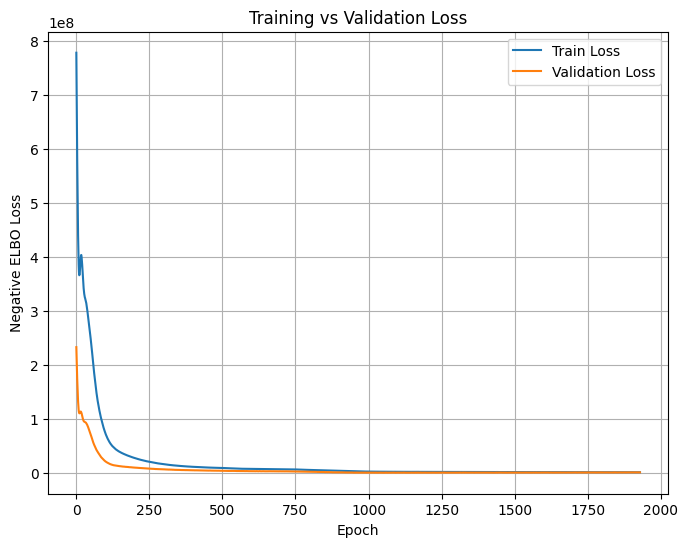

In [11]:
num_features = len(selected_HIs_dch_list)+ len(selected_HIs_ch_list)
print(f'Train Cell Numbers: {train_conditions}, Test Cell Number: {test_conditions}')
SoH_RUL = 'RUL'

# Create the Bayesian model for RUL Prediction
bayesian_model_RUL = BayesianRegressionNetwork(
    input_dim=num_features,
    hidden_layers=[32, 16, 8],
    output_dim=1,
    samples=5,
    num_batches=20,
    pi=0.5,
    sigma1=5,
    sigma2=0.1,
    google_init=True,
    scalar_mixture_prior=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

train_losses, val_losses = bayesian_model_RUL.fit_bbb(
    inputs_train, RULs_train,
    inputs_test, RULs_test,
    optimizer=optimizer,
    num_features= num_features,
    epochs=2000,
    use_early_stopping=False,
    patience=100,
    verbose=True,
    start_log_epoch=70
)

bayesian_model_RUL.plot_losses()

Mean Absolute Error (MAE): 168.3836
Mean Absolute Percentage Error (MAPE): 0.1248
Root Mean Squared Error (RMSE): 199.0749
R² Score: 0.9926


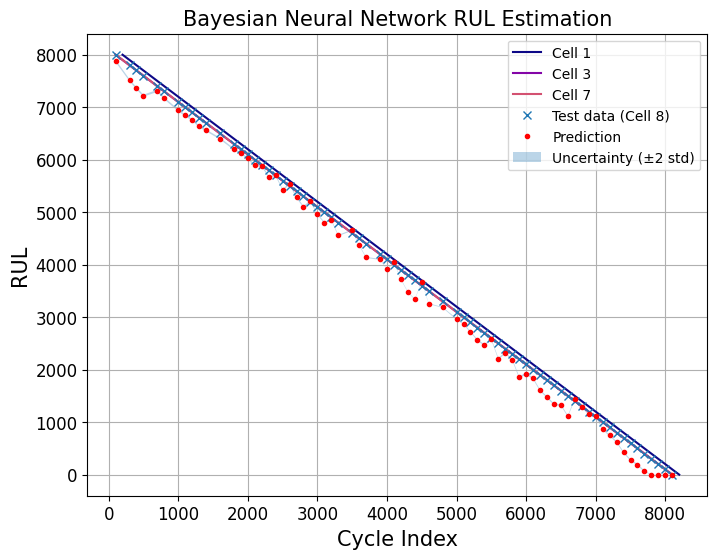

In [13]:
SoH_RUL = 'RUL'

output_test = RULs_test
cycle_filtered, RUL_true_filtered, RUL_pred_filtered, mean_pred, std_pred = prediction(model = bayesian_model_RUL, SoH_RUL = SoH_RUL,
                                                                                    input_test = inputs_test, output_test=output_test, num_features=num_features, num_path=50, threshold=2)
mae = mean_absolute_error(RUL_true_filtered, RUL_pred_filtered)
mape = mean_absolute_percentage_error(RUL_true_filtered, RUL_pred_filtered)
rmse = np.sqrt(mean_squared_error(RUL_true_filtered, RUL_pred_filtered))
r2 = r2_score(RUL_true_filtered, RUL_pred_filtered)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Plot_predictions(bayesian_model_RUL, inputs_test=inputs_test, output_test=output_test,
                Cycle_list=Cycle_list, Capacity_list=Capacity_list, RUL_list=RUL_list,
                SoH_RUL=SoH_RUL, num_features=num_features,
                train_conditions=train_conditions, test_conditions=test_conditions, num_path=50)

In [ ]:
# Save RUL Predictions

data = [RUL_true_filtered, RUL_pred_filtered]

with open(f'RUL_Cell{test_conditions[0]}.csv', 'w', newline='') as file:
         writer = csv.writer(file)
         writer.writerows(data)